# Different Numerical Schemes to Solve Riemann Shock tube Problem
### Schemes Implemented --  Lax frierich, HLL , HLLC

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

#### Configuration

In [21]:
NUM_VARS = 3
MAX_TIME_ITER = 1000000
NUM_CELLS = 200
NUM_GHOST_CELLS = 1
num_rk_steps = 1
CFL = 0.8
Test_cases = (300,0.000,10.0 ,300.0 ,0.000,1.0)  ###Temp_left,u_left,p_left,Temp_right,u_right,p_right
STOPPING_TIME = 5.5e-4
x_max = 0.5
x_min = -0.5
R = 287.1
gamma = 1.4

#### Class object is created for storing data related to each cell

In [22]:
class CELL:
    def __init__(self, U=None, dx=None, centroid=None, F = None, U_minus = None, U_plus = None):
        self.U = U
        self.dx = dx
        self.centroid = centroid
        self.F = F
        self.U_minus =U_minus
        self.U_plus = U_plus

##### Functions to Convert Primitive variables to Conservative and vice-versa. 

In [23]:
def primitive_to_conservative(primitive_var):
    conservative_var = []
    rho = primitive_var[0]
    u = primitive_var[1]
    p = primitive_var[2]
    E = rho*(0.5*u*u + p/(gamma-1.0)/rho)
    conservative_var.append(rho)
    conservative_var.append(rho*u)
    conservative_var.append(E)
    return conservative_var

def conservative_to_primitive(conservative_var):
    primitive_var = []
    rho = conservative_var[0]
    u = conservative_var[1]/conservative_var[0]
    e = conservative_var[2]/conservative_var[0]
    p = (e - 0.5*u*u)*(gamma-1.0)*rho
    primitive_var.append(rho)
    primitive_var.append(u)
    primitive_var.append(p)
    return primitive_var

#### EOS

In [24]:
def get_rho_eos(T,p):
    return p/R/T

def get_p_eos(T,rho):
    return rho*R*T

def get_T_eos(p,rho):
    return p/rho/R

#### Initialize Solution and Geometry

In [25]:
def initialize(cells):
    prim_left = [Test_cases[i] for i in range(NUM_VARS)]
    prim_right = [Test_cases[i] for i in range(NUM_VARS,2*NUM_VARS)]
    prim_left[2] *= 101325.0
    prim_right[2] *= 101325.0
    prim_left[0] = get_rho_eos(prim_left[0],prim_left[2]) 
    prim_right[0] = get_rho_eos(prim_right[0],prim_right[2])
    cons_left = primitive_to_conservative(prim_left) 
    cons_right = primitive_to_conservative(prim_right)
    for i in range(NUM_CELLS + 2*NUM_GHOST_CELLS):
        cells[i].U_minus = [0.0]*NUM_VARS
        cells[i].U_plus = [0.0]*NUM_VARS
        if(cells[i].centroid < 0.0):
            cells[i].U = deepcopy(cons_left)
        else:
            cells[i].U = deepcopy(cons_right)

def set_up_geometry():
    cells = []
    dx_x =(x_max- x_min)/(NUM_CELLS)
    for i in range(-NUM_GHOST_CELLS, NUM_CELLS + NUM_GHOST_CELLS):
        cells.append(CELL(centroid = x_min + i*dx_x + 0.5*dx_x , dx = dx_x))
    return cells

#### Functions to find max eigenvalue and flux for a conservative variable vector

In [26]:
def max_eigenvalue(U):
    primitive_vars = conservative_to_primitive(U)
    return abs(primitive_vars[1]) + np.sqrt(gamma*primitive_vars[2]/primitive_vars[0])

def Flux(U):
    P = conservative_to_primitive(U)
    F = [U[1], U[1]*P[1] + P[2] , (U[2]+P[2])*P[1]]
    return F

In [27]:
def get_dt(cells):
    dx = cells[0].dx
    dt = [ dx/max_eigenvalue(cells[i].U) for i in range(NUM_CELLS + 2*NUM_GHOST_CELLS)] 
    return min(dt)*CFL

### Schemes Implemented --  Lax frierich, Lax Wendroff, HLL , HLLC

In [28]:
def laxfriedrich(UL,UR):
    fl = Flux(UL)
    fr = Flux(UR)
    max_ev = max(max_eigenvalue(UL),max_eigenvalue(UR))
    flux = [0.5*(fl[var]+fr[var]) - 0.5*max_ev*(UR[var] - UL[var]) for var in range(NUM_VARS)]
    return flux

def hll(UL,UR):
    PL = conservative_to_primitive(UL)
    PR = conservative_to_primitive(UR)
    SL = min( PR[1] - np.sqrt(gamma*PR[2]/PR[0]), PL[1] - np.sqrt(gamma*PL[2]/PL[0]))
    SR = max( PL[1] + np.sqrt(gamma*PL[2]/PL[0]), PR[1] + np.sqrt(gamma*PR[2]/PR[0]))
    fl = Flux(UL)
    fr = Flux(UR)
    U_hll = [(SR*UR[var] - SL*UL[var] + fl[var] - fr[var])/(SR-SL) for var in range(NUM_VARS)]
    F_hll = [fl[var] + SL*(U_hll[var] - UL[var]) for var in range(NUM_VARS)]
    if SL >= 0:
        return fl
    elif SR <= 0:
        return fr
    elif SL<=0 and SR >=0:
        return F_hll
    
def hllc(UL,UR):
    PL = conservative_to_primitive(UL)
    PR = conservative_to_primitive(UR)
    SL = min( PR[1] - np.sqrt(gamma*PR[2]/PR[0]), PL[1] - np.sqrt(gamma*PL[2]/PL[0]))
    SR = max( PL[1] + np.sqrt(gamma*PL[2]/PL[0]), PR[1] + np.sqrt(gamma*PR[2]/PR[0]))
    fl = Flux(UL)
    fr = Flux(UR)
    S_star = (PR[2] -PL[2] + PL[0]*PL[1]*(SL - PL[1]) - PR[0]*PR[1]*(SR - PR[1]) )/(PL[0]*(SL - PL[1]) - PR[0]*(SR - PR[1]))
    dummy_l = [1.0, S_star, UL[2]/UL[0] + (S_star - PL[1])*(S_star + PL[2]/(PL[0]*(SL-PL[1])))]
    dummy_r = [1.0, S_star, UR[2]/UR[0] + (S_star - PR[1])*(S_star + PR[2]/(PR[0]*(SR-PR[1])))]
    U_star_l = [PL[0]*(SL - PL[1])/(SL-S_star)*dummy_l[var] for var in range(NUM_VARS)]
    U_star_r = [PR[0]*(SR - PR[1])/(SR-S_star)*dummy_r[var] for var in range(NUM_VARS)]
    F_star_l = [fl[var] + SL*(U_star_l[var] - UL[var]) for var in range(NUM_VARS)]
    F_star_r = [fr[var] + SR*(U_star_r[var] - UR[var]) for var in range(NUM_VARS)]
    if SL >= 0:
        return fl
    elif SR <= 0:
        return fr
    elif SL<=0 and S_star >=0:
        return F_star_l
    elif SR >=0 and S_star <= 0:
        return F_star_r

#### Function to Update Ghost cells, calculate flux at the interface using one of the schemes, and then update the main cells.

In [29]:
def update_ghost_cells(cells):
    for cell_num in range(0,NUM_GHOST_CELLS):
        for var in range(NUM_VARS):
            cells[cell_num].U[var] = cells[NUM_GHOST_CELLS].U[var]
    for cell_num in range(NUM_CELLS + NUM_GHOST_CELLS, NUM_CELLS + 2*NUM_GHOST_CELLS):
        for var in range(NUM_VARS):
            cells[cell_num].U[var] = cells[NUM_CELLS + NUM_GHOST_CELLS -1].U[var]
            
def calculateflux(cells,scheme = None):
    for interface in range(NUM_CELLS+2*NUM_GHOST_CELLS):
        cells[interface].F = [0.0]*NUM_VARS
    for interface in range(NUM_GHOST_CELLS,NUM_CELLS+NUM_GHOST_CELLS+1):
        UL = deepcopy(cells[interface-1].U)
        UR = deepcopy(cells[interface].U)
        flux = scheme(UL,UR)
        for var in range(NUM_VARS):
            cells[interface].F[var] -= flux[var]
            cells[interface-1].F[var] += flux[var]
    return cells

def updatecells(cells,dt):
    dx = cells[0].dx
    for i in range(NUM_GHOST_CELLS,NUM_CELLS+NUM_GHOST_CELLS):
        for var in range(NUM_VARS):
            cells[i].U[var] = cells[i].U[var] - dt/dx*cells[i].F[var]
    return cells

#### Function to find the properties (density, pressure and velocity) of the flow after the stopping time.

In [30]:
def plot_scheme(scheme):
    cells = set_up_geometry()
    initialize(cells)
    last_step = False
    time = 0.0
    for iter in range(MAX_TIME_ITER):
        dt = get_dt(cells)
        if (dt + time > STOPPING_TIME):
            dt = STOPPING_TIME - time
            last_step = True
        time += dt
        update_ghost_cells(cells)
        calculateflux(cells, scheme)
        updatecells(cells,dt)
        if last_step == True: break
    x = [cells[i].centroid for i in range(NUM_GHOST_CELLS,NUM_CELLS + NUM_GHOST_CELLS )]
    P = [conservative_to_primitive(cells[i].U) for i in range(NUM_GHOST_CELLS,NUM_CELLS + NUM_GHOST_CELLS)]
    rho = [P[i][0] for i in range(NUM_CELLS)]
    u = [P[i][1] for i in range(NUM_CELLS)]
    p = [P[i][2] for i in range(NUM_CELLS)]
    rho = rho / np.max(rho)
    u = u / np.max(u)
    p = p / np.max(p)
    return x,rho,u,p

#### Main function

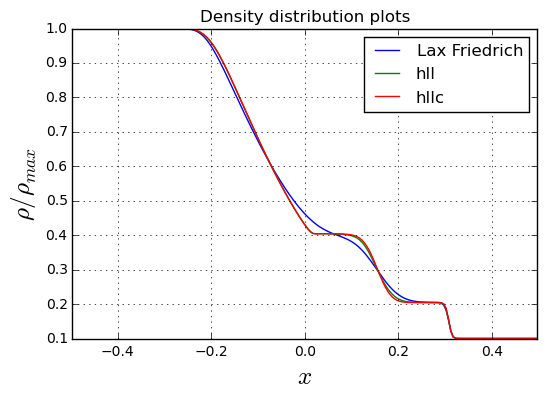

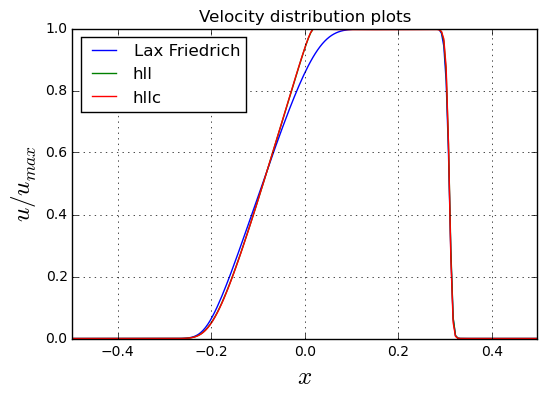

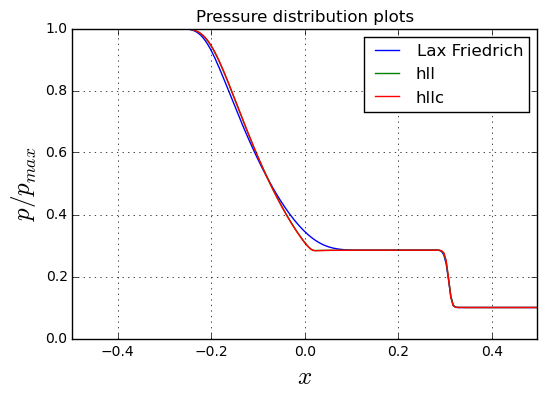

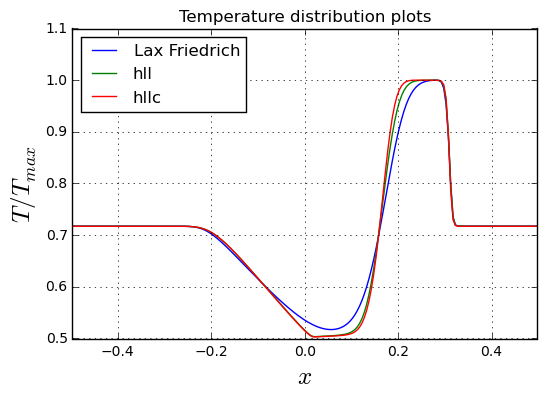

In [31]:
if __name__ == '__main__':
    schemes = ["Lax Friedrich","hll","hllc"]
    x1,rho1,u1,p1 = plot_scheme(laxfriedrich)
    T1 = [get_T_eos(p1[i],rho1[i]) for i  in range(len(p1))]
    T1 = T1/np.max(T1)
    x2,rho2,u2,p2 = plot_scheme(hll)
    T2 = [get_T_eos(p2[i],rho2[i]) for i  in range(len(p2))]
    T2 = T2/np.max(T2)
    x3,rho3,u3,p3 = plot_scheme(hllc)
    T3 = [get_T_eos(p3[i],rho3[i]) for i  in range(len(p3))]
    T3 = T3/np.max(T3)
    plt.figure()
    plt.plot(x1, rho1, label= schemes[0])
    plt.plot(x2, rho2, label=schemes[1])
    plt.plot(x3,rho3, label=schemes[2])
    plt.xlim((np.min(x1), np.max(x1)))
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("$\\rho/\\rho_{max}$", fontsize=18)
    plt.grid()
    plt.title("Density distribution plots")
    plt.legend(loc="best")
    plt.show()
    plt.figure()
    plt.plot(x1, u1, label= schemes[0])
    plt.plot(x2, u2, label=schemes[1])
    plt.plot(x3,u3, label=schemes[2])
    plt.xlim((np.min(x1), np.max(x1)))
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("$u/u_{max}$", fontsize=18)
    plt.grid()
    plt.title("Velocity distribution plots")
    plt.legend(loc="best")
    plt.show()
    plt.figure()
    plt.plot(x1, p1, label= schemes[0])
    plt.plot(x2, p2, label=schemes[1])
    plt.plot(x3, p3, label=schemes[2])
    plt.xlim((np.min(x1), np.max(x1)))
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("$p/p_{max}$", fontsize=18)
    plt.grid()
    plt.title("Pressure distribution plots")
    plt.legend(loc="best")
    plt.show() 
    plt.figure()
    plt.plot(x1, T1, label= schemes[0])
    plt.plot(x2, T2, label=schemes[1])
    plt.plot(x3, T3, label=schemes[2])
    plt.xlim((np.min(x1), np.max(x1)))
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("$T/T_{max}$", fontsize=18)
    plt.grid()
    plt.title("Temperature distribution plots")
    plt.legend(loc="best")
    plt.show()